# Modeling and Simulation in Python

Starter code for the orbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [2]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [3]:
# And an initial condition (with everything in SI units)

r_0 = 147e9 * m

init = State(r = r_0,
             v = 0 * m / s)

,values
r,147000000000.0 meter
v,0.0 meter / second


In [4]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1e7 * s)

,values
init,r 147000000000.0 meter v 0.0 meter / s...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,10000000.0 second


In [5]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    r, v = state
    unpack(system)
    
    force = G * m1 * m2 / r**2
    return force

In [6]:
universal_gravitation(init, system)

<Quantity(3.6686485997501037e+22, 'newton')>

In [7]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)    

    force = universal_gravitation(state, system)
    dydt = v
    dvdt = -force / m2
    
    return dydt, dvdt

In [8]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>)

In [9]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    r, v = state
    return r - system.r_final

In [10]:
# Always test the event function!

event_func(init, 0, system)

<Quantity(146298121000.0, 'meter')>

In [11]:
# Finally we can run the simulation

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[5432658.401694092]]
nfev,236
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [12]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(5432658.401694092, 'second')>

In [13]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(62.877990760348276, 'day')>

In [14]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

In [15]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [16]:
# Scaling the distance to million km

r = results.r / 1e9;

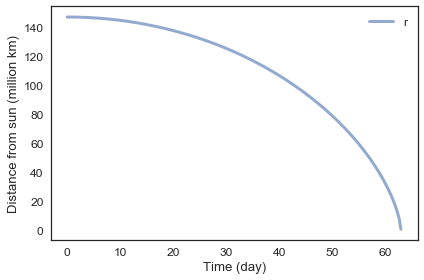

In [17]:
# And plotting

plot(r, label='r')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

### Earth orbiting the sun

Let's try to follow Allen's instructions!

In [18]:
# Step 1
init = State(x = r_0, y = 0 * m,
            vx = 0 * m / s, vy = 0 * m / s)

# Need to redefine the system object in order to pick up the new initial condition
system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1e7 * s)

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,10000000.0 second


In [19]:
# Step 2
def universal_gravitation(state, system):
    """Computes gravitational force as a vector.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    r = Vector(x, y)
    force_mag = G * m1 * m2 / r.mag**2
    force_dir = -r.hat()
    
    # Need to multiply direction by magnitude in order to get a vector!
    return force_dir * force_mag

In [20]:
universal_gravitation(init, system)

<Quantity([-3.6686486e+22 -0.0000000e+00], 'newton')>

In [21]:
# Step 3
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: x, y, vx, vy
    t: time
    system: System object
    
    returns: derivatives of x, y, vx, vy
    """
    x, y, vx, vy = state
    unpack(system)
    
    r = Vector(x, y)
    
    force = universal_gravitation(state, system)
    a = force / m2
    
    return vx, vy, a.x, a.y

In [22]:
slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [23]:
# Step 4
results, details = run_ode_solver(system, slope_func)
details

# This runs, but there were problems in the sense that we got a required step size error ...

,values
sol,None
t_events,[]
nfev,632
njev,0
nlu,0
status,-1
message,Required step size is less than spacing betwee...
success,False


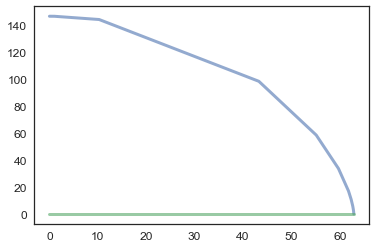

In [24]:
# Step 5
results.index /= (60 * 60 * 24)
results.x /= 1e9
results.y /= 1e9
plot(results.x)
plot(results.y)

In [25]:
# Step 6
init = State(x = r_0, y = 0 * m,
            vx = 0 * m / s, vy = 30330 * m / s)

# Need to redefine the system object in order to pick up the new initial condition
system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1e7 * s)

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,10000000.0 second


In [26]:
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,110
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


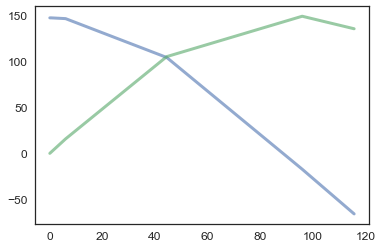

In [27]:
results.index /= (60 * 60 * 24)
results.x /= 1e9
results.y /= 1e9
plot(results.x)
plot(results.y)

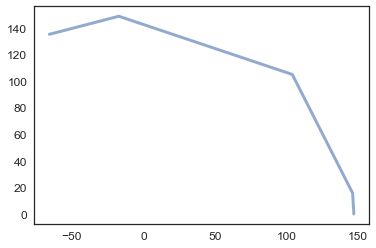

In [28]:
# Step 7
plot(results.x, results.y, label='trajectory')

In [29]:
# Step 8
init = State(x = r_0, y = 0 * m,
            vx = 0 * m / s, vy = 30330 * m / s)

oneYear = (1 * UNITS.year).to(s)

# Need to redefine the system object in order to pick up the new initial condition
# (And still need to pass t_end even if we don't use it)
system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0,
                t_end=oneYear)

ts = linspace(t_0, oneYear, 201)
results, details = run_ode_solver(system, slope_func, t_eval=ts)

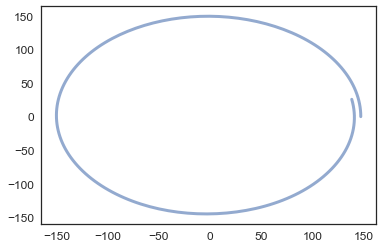

In [30]:
results.index /= (60 * 60 * 24)
results.x /= 1e9
results.y /= 1e9
plot(results.x, results.y, label='trajectory')

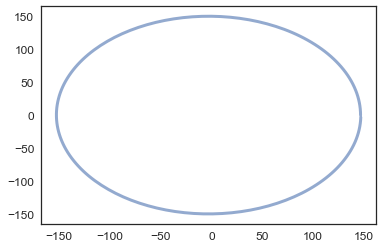

In [31]:
# Step 9
init = State(x = r_0, y = 0 * m,
            vx = 0 * m / s, vy = 30330 * m / s)

oneYear = (1 * UNITS.year).to(s)

# Need to redefine the system object in order to pick up the new initial condition
# (And still need to pass t_end even if we don't use it)
system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0,
                t_end=oneYear)

ts = linspace(t_0, oneYear, 201)
results, details = run_ode_solver(system, slope_func, t_eval=ts, method='RK23')

results.index /= (60 * 60 * 24)
results.x /= 1e9
results.y /= 1e9
plot(results.x, results.y, label='trajectory')